<a href="https://colab.research.google.com/github/Vincent-Emma/DS-Unit-2-Applied-Modeling/blob/master/Vince's_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [4]:
y_train = train['Fail']
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train,train_size=0.8,test_size=0.2,
                             stratify=train['Fail'], random_state = 42)

In [6]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,4.153200e+04,4.152800e+04,41510.000000,41385.000000,41385.000000,41532.000000
mean,1.327653e+06,1.548519e+06,60628.746591,41.879559,-87.676578,0.258620
std,6.211008e+05,9.031007e+05,22.979353,0.081205,0.059327,0.437882
min,4.425100e+04,0.000000e+00,60007.000000,41.646371,-87.914428,0.000000
25%,6.793452e+05,1.139382e+06,60614.000000,41.830269,-87.707725,0.000000
50%,1.418942e+06,1.959154e+06,60625.000000,41.890196,-87.666745,0.000000
75%,1.946773e+06,2.215531e+06,60643.000000,41.939168,-87.634537,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [7]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,41532,41028,41357,41523,41532,41488,41525,41532,41531,33789,41385
unique,15705,15086,292,3,13209,35,1,2251,46,33727,12744
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,527,640,27449,30143,591,41319,41525,45,19356,3,591


In [8]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            504
License #             4
Facility Type       175
Risk                  9
Address               0
City                 44
State                 7
Zip                  22
Inspection Date       0
Inspection Type       1
Violations         7743
Latitude            147
Longitude           147
Location            147
Fail                  0
dtype: int64

In [9]:
test.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            222
License #             2
Facility Type        87
Risk                  7
Address               0
City                 18
State                 2
Zip                   8
Inspection Date       0
Inspection Type       0
Violations         3280
Latitude             61
Longitude            61
Location             61
Fail                  0
dtype: int64

In [0]:
drop = ['Fail','AKA Name','Violations','Facility Type']
X_train = train.drop(columns=drop)
y_train = train['Fail']
X_val = val.drop(columns=drop)
y_val = val['Fail']
X_test = test.drop(columns=drop)
y_test = test['Fail']

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train);

In [12]:
print ('Validataion score:', pipeline.score(X_val,y_val))

Validataion score: 0.75115562403698


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [13]:

import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_train, fill_value=majority_class)
accuracy_score(y_train, y_pred)

0.741380140614466

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

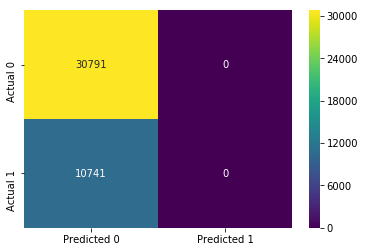

In [15]:
plot_confusion_matrix(y_train, y_pred);

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85     30791
           1       0.00      0.00      0.00     10741

    accuracy                           0.74     41532
   macro avg       0.37      0.50      0.43     41532
weighted avg       0.55      0.74      0.63     41532



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.metrics import roc_auc_score

In [18]:
y_val_pred_proba = pipeline.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_val_pred_proba)

0.6934706265511761

In [19]:
y_test_pred_proba = pipeline.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_test_pred_proba)

0.6988406221141273

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [20]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[18:40:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.48578	validation_1-rmse:0.485823
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.473965	validation_1-rmse:0.474006
[2]	validation_0-rmse:0.464176	validation_1-rmse:0.464133
[3]	validation_0-rmse:0.456052	validation_1-rmse:0.456009
[4]	validation_0-rmse:0.449354	validation_1-rmse:0.449231
[5]	validation_0-rmse:0.443809	validation_1-rmse:0.443716
[6]	validation_0-rmse:0.439244	validation_1-rmse:0.439127
[7]	validation_0-rmse:0.435508	validation_1-rmse:0.435361
[8]	validation_0-rmse:0.432442	validation_1-rmse:0.432325
[9]	validation_0-rmse:0.429884	validation_1-rmse:0.429723
[10]	validation_0-rmse:0.427798	validation_1-rmse:0.427659
[11]	validation_0-rmse:0.426083	validation_1-rmse:0.425898
[12]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [37]:
from sklearn.model_selection import cross_val_score

model = XGBClassifier()
cross_val_score(model, X_train_encoded, y_train, 
                scoring='accuracy', cv=3, n_jobs=-1)

array([0.75507403, 0.75563421, 0.74983746])

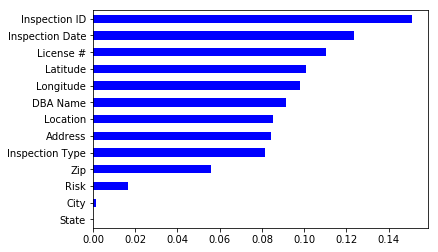

In [25]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='blue');

In [26]:
!pip install eli5

In [27]:
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)

[18:43:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
!pip install pdpbox

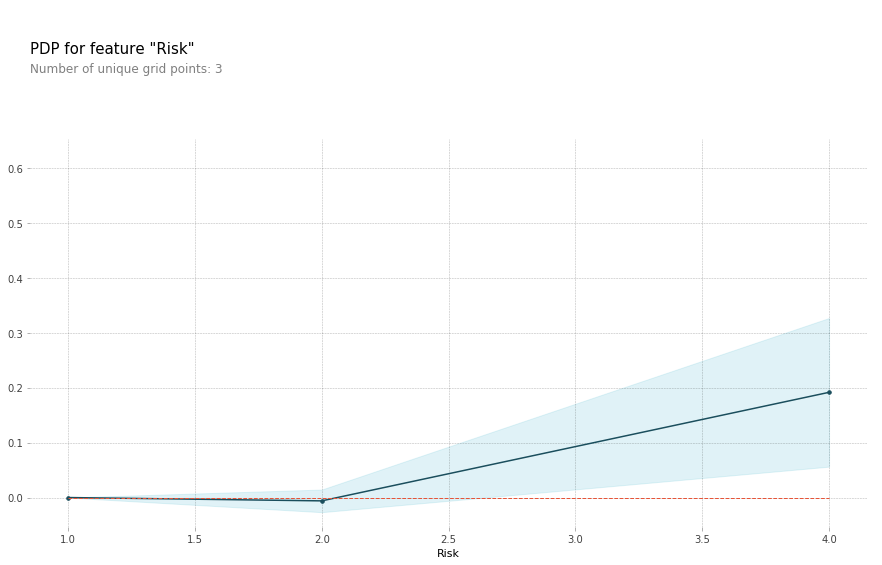

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Risk'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

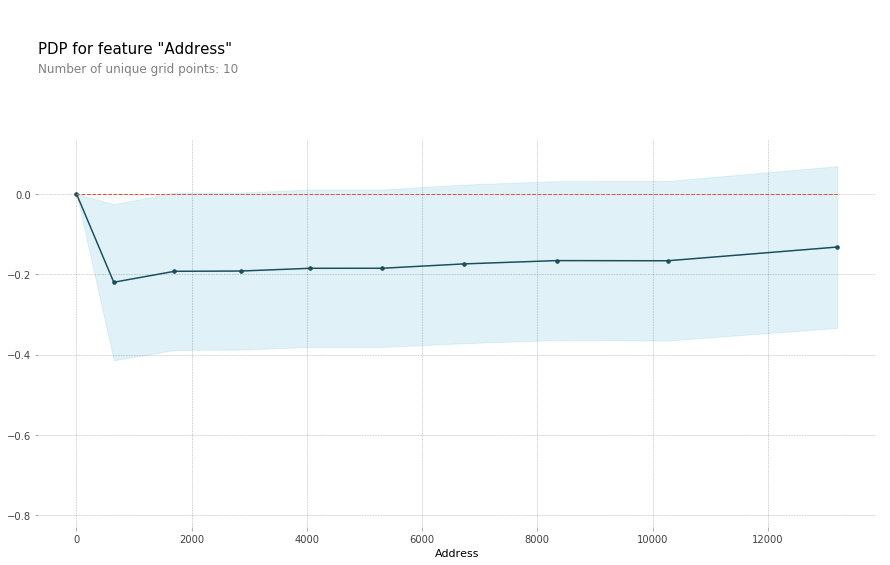

In [32]:
feature = 'Address'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [33]:
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train),
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc',
         early_stopping_rounds=10)

[0]	validation_0-auc:0.67502	validation_1-auc:0.657827
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.67502	validation_1-auc:0.657827
[2]	validation_0-auc:0.676334	validation_1-auc:0.659569
[3]	validation_0-auc:0.685045	validation_1-auc:0.668552
[4]	validation_0-auc:0.685274	validation_1-auc:0.668868
[5]	validation_0-auc:0.686987	validation_1-auc:0.669751
[6]	validation_0-auc:0.686987	validation_1-auc:0.669751
[7]	validation_0-auc:0.689414	validation_1-auc:0.671196
[8]	validation_0-auc:0.689419	validation_1-auc:0.67122
[9]	validation_0-auc:0.689448	validation_1-auc:0.67132
[10]	validation_0-auc:0.690764	validation_1-auc:0.671494
[11]	validation_0-auc:0.691981	validation_1-auc:0.672413
[12]	validation_0-auc:0.69222	validation_1-auc:0.672517
[13]	validation_0-auc:0.692644	validation_1-auc:0.673371
[14]	validation_0-auc:0.69324	validation_1-auc:0.673945
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
X_test_random = X_test.sample(n=1)
print(X_test_random)

      Inspection ID  ...                                           Location
9823        1976942  ...  {'longitude': '-87.70896897170057', 'latitude'...

[1 rows x 13 columns]


In [35]:
row = X_test.iloc[[10594]]
y_test.iloc[[10594]]

10594    0
Name: Fail, dtype: int64

In [36]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)